# Introduction

In this example, we will look at the prospects of a potential geothermal well that produces heat for a district heating network. Since geological and operational parameters are uncertain, the prediction should also incorporate uncertainty. Monte Carlo it is then!

It is an overly simplified example of course. In reality, some parameters will themselves be results from other simulations and so on.

First, we will define the input parameters for the simulation and their uncertainty.

Then, we will compute predictions based on these parameters.

Finally, we will inspect the results and perform a sensitivity analysis.

# Setup

In [1]:
#As a first step, we need some imports (inlcuding the mcoo module)
import sys
sys.path.append('../PyMoCa')
import PyMoCa as mc, scipy.stats as stats, numpy as np, pandas as pd

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
#create a new simulation with 10.000 realisations
nmc = 10000
mysim = mc.Simulation('geothermal', nmc = nmc, savefigs = False)


# Set up model parameters

Prepare the input parameters for the simulation. Parameters can be described by three different attributes:

* **.dist:** statistical distribution of the parameter. For the simulation, random numbers will de drawn from the distribution.
* **.hist**: historical / empirical data. This data can not be used directly for simulations. However, since usually a statistical distribution will be fit to this data, it can be included in plots and summaries.
* **.s**: Simulation data. Use this attribute, if parameter data is available from outside (e.g. another simulator).

## Geological parameters

In [3]:
#flow rate under expected operational parameters

dist = stats.triang(1, loc = 60, scale = 40)
mysim.add(mc.parameter('q', dist = dist, unit = 'l/s')) #add parameter

In [4]:
#reservoir temperature gradient [K/100 m]. Here there is some existing data we can fit on and store in the parameter.
d_rtg = pd.read_csv('rtg.txt') #read the existing data
rtg = (d_rtg
       .to_numpy()
       .flatten())

fitparams = stats.triang.fit(rtg) #fit
fit_RTG = stats.triang(*fitparams)

mysim.add(mc.parameter('RTG', dist = fit_RTG, hist_data = rtg, unit = '°C/1000 m')) #add parameter

In [5]:
#add some more parameters we can later work with

#depth of top reservoir
mysim.add(mc.parameter('Top Reservoir', dist = stats.uniform(loc = 2000, scale = 1000), unit = 'm TVD'))

#ESP head
mysim.add(mc.parameter('ESP head', dist = stats.norm(50, 10), unit = '-'))

## Adding parameters: a closer look

The following is equally true for results

In [6]:
#I can access and modify parameters in the simulation by using mysim['parameter name']

#maybe there was a typo I need to correct (100 instead of 60)
mysim['q'].dist = stats.triang(1, loc = 100, scale = 40)

In [7]:
#however, i can not add a new parameter this way
#mysim['new parameter'] = mc.parameter('new parameter')

In [8]:
#An element's name must be unique
#mysim.add(mc.result('q'))

In [9]:
#I don't have to provide simulation data (.s) with an element...
mysim.add(mc.parameter('empty test'))

In [10]:
# Delete elements...
mysim.remove('empty test')

In [11]:
#...but if I do, it needs to be of the correct length (nmc attribute of simulation)
#mysim.add(mc.parameter('empty test', s = np.ones(12)))

## Operational parameters

some more parametes...

In [12]:
#reinjection temperature [°C]
mysim.add(mc.parameter('TInj', dist = stats.uniform(loc = 40, scale = 20), unit = '°C'))

#efficiency of submersible pump [-]
mysim.add(mc.parameter('nEsp', dist = stats.triang(loc = 0.5, scale = 0.8, c = 0.5)))

## Parameter realisation

The parameters that were initialised only with a distribution lack actual values to compute results with. They first need to be generated. A number (parameter nmc) of values will be generated based on the parameter distribution. 

If, instead of a theoretical distribution, a set of actual values is known, these can be stored as .s attribute of a parameter and will not be affected by the realise_parameter_sets() method

In [13]:
mysim.realise_parameter_sets()

## Parameter overview

Before we use the parameters for computation, let's have a look at them. A parameter plot consists of a histogram of the simulation (and, if present, the historical, data), the underlying theoretical statistical distribution and a representation of the 0.1, 0.5, 0.9 quantiles as well as min and max values.

,n / fit,unit,mean,std,min,max,P10,P50,P90
fit,uniform,°C,50.00,5.77,40.00,60.00,58.00,50.00,42.00
sim,"10,000.00",°C,50.10,5.75,40.00,60.00,58.04,50.05,42.03


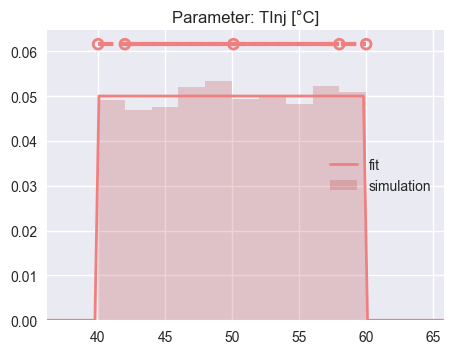

In [14]:
#i can now display a summary table or plot for each parameter...
display(mysim['TInj'].summary)
mysim['TInj'].plot()

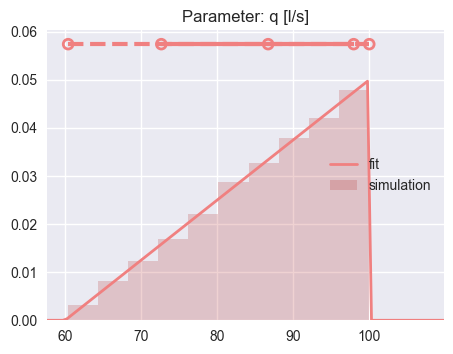

,n / fit,unit,mean,std,min,max,P10,P50,P90
fit,triang,l/s,86.67,9.43,60.00,100.00,97.95,88.28,72.65
sim,"10,000.00",l/s,86.70,9.44,60.32,100.00,97.94,88.25,72.69


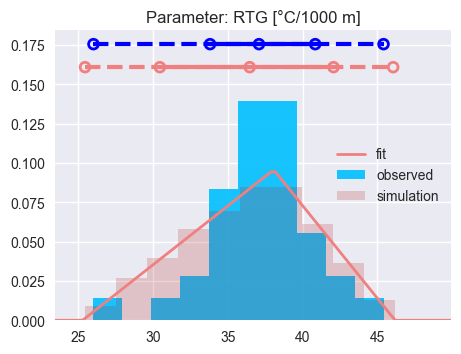

,n / fit,unit,mean,std,min,max,P10,P50,P90
fit,triang,°C/1000 m,36.52,4.30,25.28,46.20,42.07,36.85,30.45
data,37.00,°C/1000 m,37.09,3.40,26.01,45.42,40.85,36.89,33.81
sim,"10,000.00",°C/1000 m,36.47,4.33,25.45,46.16,42.06,36.81,30.36


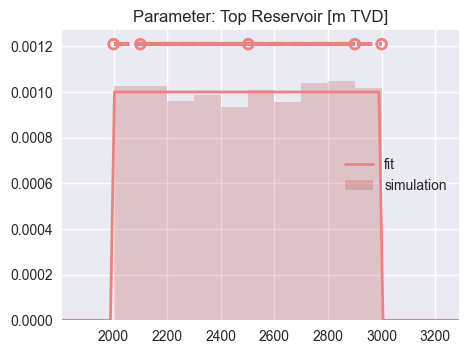

,n / fit,unit,mean,std,min,max,P10,P50,P90
fit,uniform,m TVD,"2,500.00",288.68,"2,000.00","3,000.00","2,900.00","2,500.00","2,100.00"
sim,"10,000.00",m TVD,"2,502.46",291.13,"2,000.09","2,999.96","2,901.98","2,507.35","2,096.80"


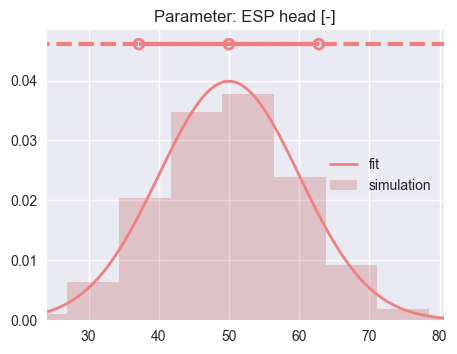

,n / fit,unit,mean,std,min,max,P10,P50,P90
fit,norm,-,50.00,10.00,-inf,inf,62.82,50.00,37.18
sim,"10,000.00",-,50.00,9.96,12.27,85.88,62.87,50.00,37.25


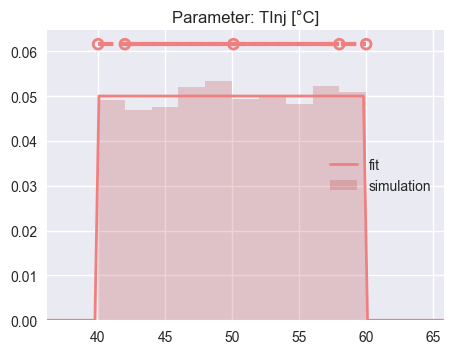

,n / fit,unit,mean,std,min,max,P10,P50,P90
fit,uniform,°C,50.00,5.77,40.00,60.00,58.00,50.00,42.00
sim,"10,000.00",°C,50.10,5.75,40.00,60.00,58.04,50.05,42.03


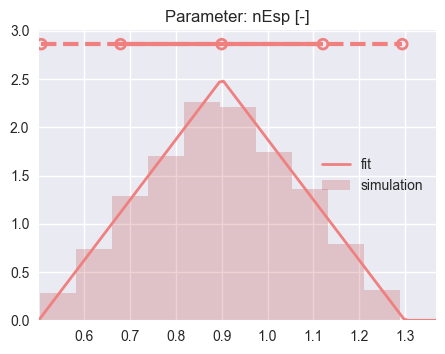

,n / fit,unit,mean,std,min,max,P10,P50,P90
fit,triang,-,0.90,0.16,0.50,1.30,1.12,0.90,0.68
sim,"10,000.00",-,0.90,0.16,0.50,1.29,1.12,0.90,0.68


In [15]:
#or for all parameters at once
mysim.show_parameters()

# Run the simulation

In [16]:
#When running the simulation, it helps having an overview of all the parameters and results 
#that are already in there.

mysim.summary

,type,unit,mean,std,min,max,P90,P50,P10
name,,,,,,,,,
q,parameter,l/s,86.70,9.44,60.32,100.00,72.69,88.25,97.94
RTG,parameter,°C/1000 m,36.47,4.33,25.45,46.16,30.36,36.81,42.06
Top Reservoir,parameter,m TVD,"2,502.46",291.13,"2,000.09","2,999.96","2,096.80","2,507.35","2,901.98"
ESP head,parameter,-,50.00,9.96,12.27,85.88,37.25,50.00,62.87
TInj,parameter,°C,50.10,5.75,40.00,60.00,42.03,50.05,58.04
nEsp,parameter,-,0.90,0.16,0.50,1.29,0.68,0.90,1.12


In [17]:
#now, we can access all realised parameter sets with the param.s attribute.
#Using these sets, the actual simulation results are calculated

#compute production temperature
res_Tp = 8 + mysim['RTG'].s * mysim['Top Reservoir'].s / 1000

#compute the heat than is produced (in MWth)
res_heat = mysim['q'].s /1000 *1000 * (res_Tp - mysim['TInj'].s) * 4.18e3 / 1e6

#compute ESP energy intake
res_ESP_intake = mysim['ESP head'].s * 1e5 * mysim['q'].s / 1000 / 1e6 / mysim['nEsp'].s

#compute COP
cop = res_heat / res_ESP_intake

#add all computed results to the simulation
mysim.add(mc.result('Production Temperature', res_Tp, unit = '°C'))
mysim.add(mc.result('Thermal power', res_heat, unit = 'MWth'))
mysim.add(mc.result('ESP intake', res_ESP_intake, unit = 'MWth'))
mysim.add(mc.result('COP', cop, unit = '-'))

# Inspect the results

## Convergence

Before we check the results, let's make sure that we've chosen the number of realisation high enough for the results to be reliable, i.e. that the results converge. A measure of convergence is the standard error of the mean. With a well chosen number of realisations, it should be negligibly small compared to the actual mean.

Element Production Temperature: Standard error of the mean after the last iteration is  0.15 or  0.15 %
Element Thermal power: Standard error of the mean after the last iteration is  0.06 or  0.35 %
Element ESP intake: Standard error of the mean after the last iteration is  0.00 or  0.31 %
Element COP: Standard error of the mean after the last iteration is  0.17 or  0.45 %


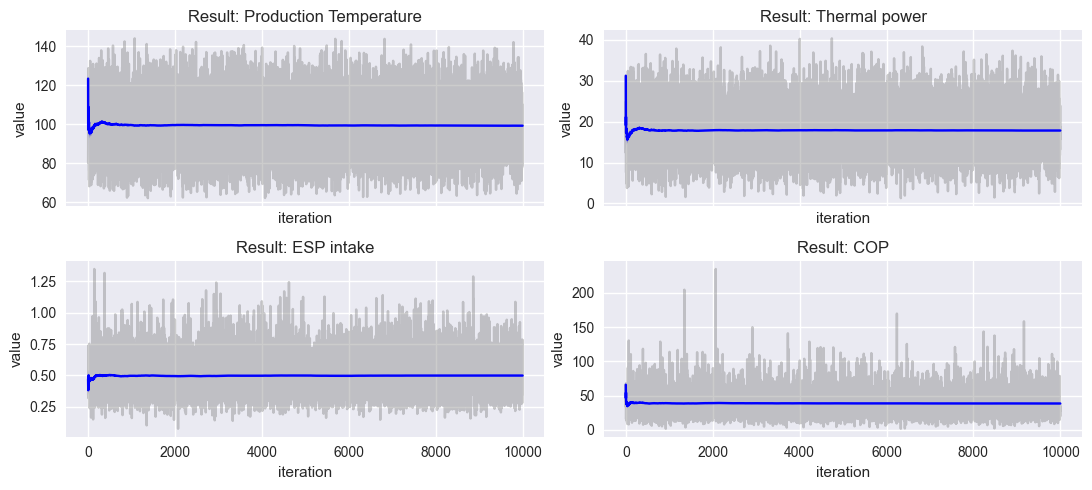

In [18]:
mysim.convergence()

# Look at the results

,n,unit,mean,std,min,max,P90,P50,P10
result,10000,MWth,17.81,6.22,1.30,40.31,9.98,17.45,26.11


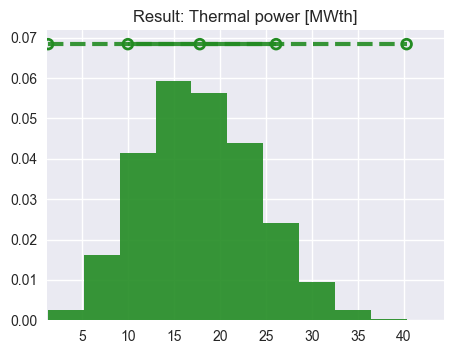

In [19]:
#again, I can either inspect a result individually...
display(mysim['Thermal power'].summary)
mysim['Thermal power'].plot()

In [20]:
#...or all at once

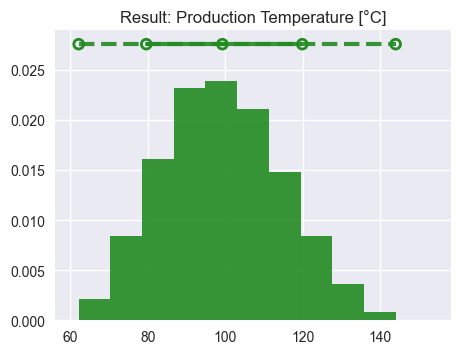

,n,unit,mean,std,min,max,P90,P50,P10
result,10000,°C,99.25,15.17,62.15,143.96,79.60,98.64,119.87


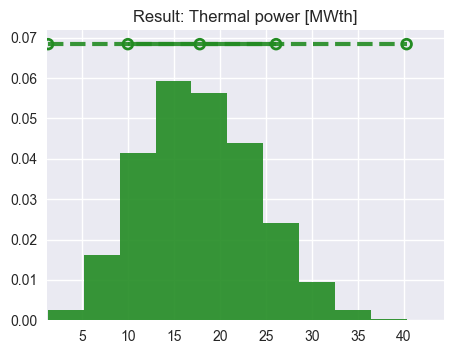

,n,unit,mean,std,min,max,P90,P50,P10
result,10000,MWth,17.81,6.22,1.30,40.31,9.98,17.45,26.11


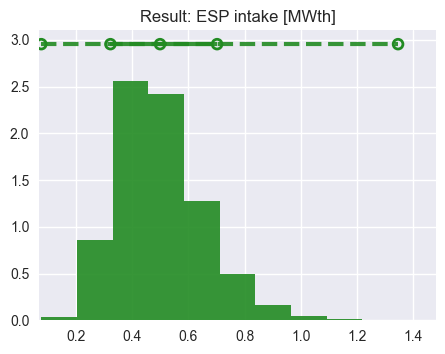

,n,unit,mean,std,min,max,P90,P50,P10
result,10000,MWth,0.50,0.15,0.08,1.35,0.32,0.48,0.70


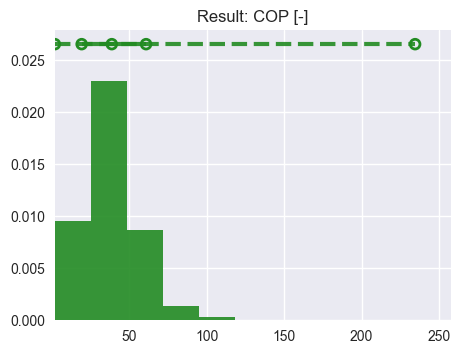

,n,unit,mean,std,min,max,P90,P50,P10
result,10000,-,38.58,17.49,1.82,234.52,19.12,36.07,60.73


In [21]:
mysim.show_results()

In [22]:
# summarize all parameters and results
display(mysim.summary)

,type,unit,mean,std,min,max,P90,P50,P10
name,,,,,,,,,
q,parameter,l/s,86.70,9.44,60.32,100.00,72.69,88.25,97.94
RTG,parameter,°C/1000 m,36.47,4.33,25.45,46.16,30.36,36.81,42.06
Top Reservoir,parameter,m TVD,"2,502.46",291.13,"2,000.09","2,999.96","2,096.80","2,507.35","2,901.98"
ESP head,parameter,-,50.00,9.96,12.27,85.88,37.25,50.00,62.87
TInj,parameter,°C,50.10,5.75,40.00,60.00,42.03,50.05,58.04
nEsp,parameter,-,0.90,0.16,0.50,1.29,0.68,0.90,1.12
Production Temperature,result,°C,99.25,15.17,62.15,143.96,79.60,98.64,119.87
Thermal power,result,MWth,17.81,6.22,1.30,40.31,9.98,17.45,26.11
ESP intake,result,MWth,0.50,0.15,0.08,1.35,0.32,0.48,0.70


# Sensitivity analysis

An (if not *the*) most result of this kind of simulations is the parameter sensitivities. Since there are many realisations, the dependencies of results on changes in the parameters can be derived. pyMoCa provides some functionality for this sensitivity analysis.

## Pairplot

For a first idea, lets just see scatter plots of all parameters against all variables. That gets us some hints of where sensitivites could lie, but no kind of quantitative information. The black vertical and horizontal line show the mean value of the corresponding result / parameter. Red dots show the highest 10% of the parameter's value, blue dots the lowest 10%.

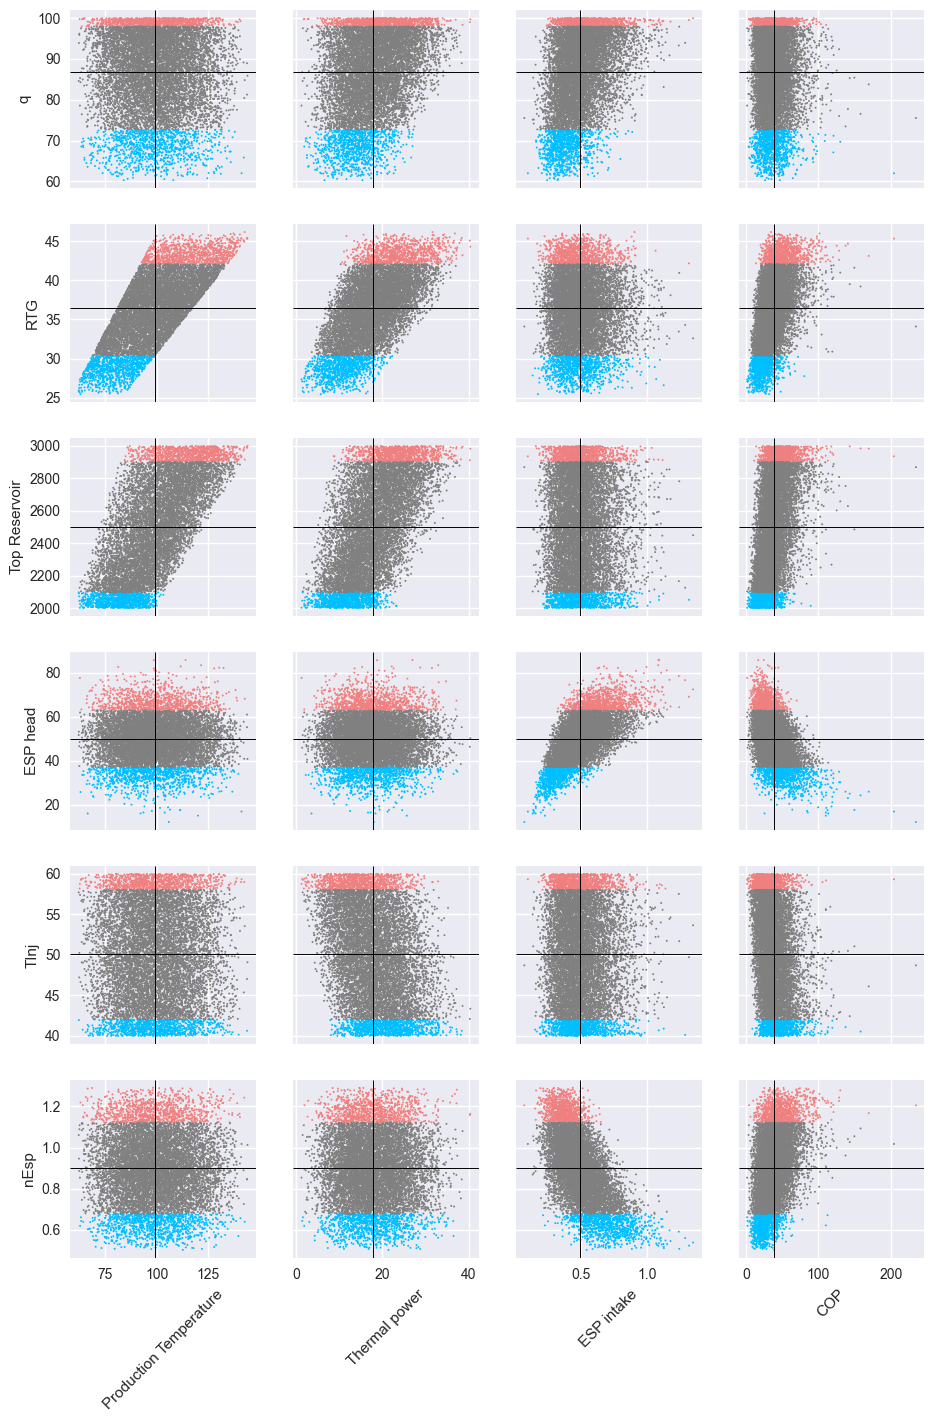

In [23]:
mysim.plot_pairplot(focus = False)

## Correlation coefficients

For a quantitative sensitivity of the results to the parameters, let's look at a matrix of correlation coefficients. We can choose between the Spearman or Pearson correlation coefficient.

In [24]:
spearmansr, pearsonr, __, __ = mysim.correlate()

print('Spearman correlation coefficients')
display(spearmansr)

print('Pearson correlation coefficients')
display(pearsonr)

Spearman correlation coefficients


,Production Temperature,Thermal power,ESP intake,COP
q,-0.00,0.31,0.36,-0.01
RTG,0.71,0.63,0.00,0.49
Top Reservoir,0.69,0.61,0.02,0.46
ESP head,0.02,0.02,0.66,-0.47
TInj,-0.00,-0.34,-0.00,-0.26
nEsp,-0.00,-0.00,-0.63,0.40


Pearson correlation coefficients


,Production Temperature,Thermal power,ESP intake,COP
q,-0.01,0.29,0.36,-0.01
RTG,0.69,0.62,0.00,0.51
Top Reservoir,0.69,0.61,0.02,0.48
ESP head,0.02,0.02,0.66,-0.43
TInj,-0.00,-0.33,-0.00,-0.27
nEsp,-0.00,-0.01,-0.62,0.40


## Tornado plots

Another helpful plot for a sensitivity analysis are Tornado plots. It shows the sensitivity of a result to all parameters, in descending order. Here, the bars show the *change in the output mean* of a result in the cases where the parameter was very high or very low.

Treat this kind of plot as qualitative information. Especially, only believe sensitivities which bars are several times larger than the standard eror of the mean of the result (grey block centered around the base value).


Please note: The sensitivities shown in a Tornado plot depend on the *uncertainty of the parameter*. If a highly influential parameter has only small uncertainty, its corresponding bar in the tornado plot will be *small*.

Pay attention to the order of the low / high bars. A "low" bar to the left of the base value and an "high" bar to the right of the base value indicate a positive correlation between the result and the parameter. If the bars are ordered the other way round, this points to a negative correlation.

Only parameters whose change-in-output-mean sensitivity is larger than the results mean standard error are plotted. Other parameters are considered insensitive.

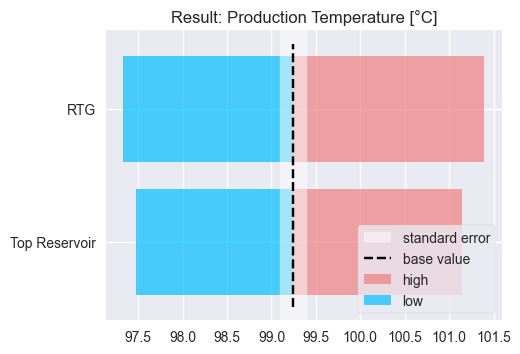

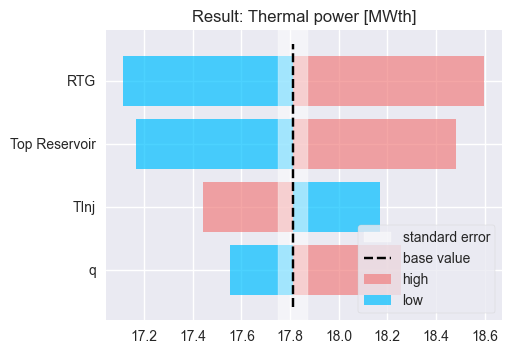

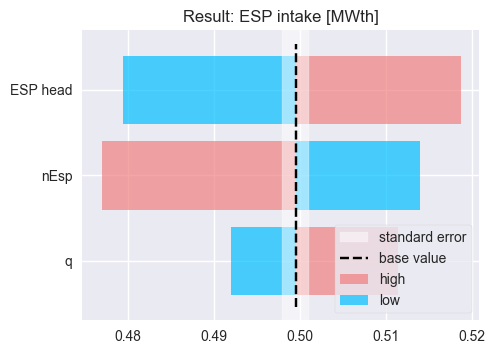

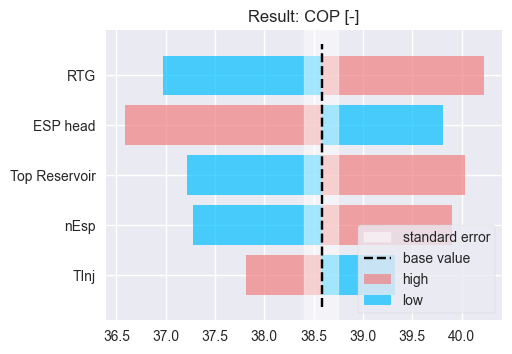

In [25]:
mysim.plot_tornado()

# Dump

Compose all results and parameters for all realisations in a dataframe, e.g. for further use in Excel or other software.

In [26]:
mysim.dump.head()

,q [l/s],RTG [°C/1000 m],Top Reservoir [m TVD],ESP head [-],TInj [°C],nEsp [-],Production Temperature [°C],Thermal power [MWth],ESP intake [MWth],COP [-]
0,95.44,44.11,"2,615.12",53.57,45.18,1.08,123.35,31.18,0.47,65.93
1,97.17,35.24,"2,051.30",42.94,46.56,1.22,80.29,13.70,0.34,39.90
2,84.72,32.77,"2,437.02",41.14,53.08,0.95,87.87,12.32,0.37,33.44
3,69.84,39.79,"2,928.09",51.12,43.70,0.99,124.52,23.59,0.36,65.33
4,76.70,40.44,"2,984.11",51.62,50.92,1.07,128.69,24.93,0.37,67.68


In [27]:
mysim.summary


,type,unit,mean,std,min,max,P90,P50,P10
name,,,,,,,,,
q,parameter,l/s,86.70,9.44,60.32,100.00,72.69,88.25,97.94
RTG,parameter,°C/1000 m,36.47,4.33,25.45,46.16,30.36,36.81,42.06
Top Reservoir,parameter,m TVD,"2,502.46",291.13,"2,000.09","2,999.96","2,096.80","2,507.35","2,901.98"
ESP head,parameter,-,50.00,9.96,12.27,85.88,37.25,50.00,62.87
TInj,parameter,°C,50.10,5.75,40.00,60.00,42.03,50.05,58.04
nEsp,parameter,-,0.90,0.16,0.50,1.29,0.68,0.90,1.12
Production Temperature,result,°C,99.25,15.17,62.15,143.96,79.60,98.64,119.87
Thermal power,result,MWth,17.81,6.22,1.30,40.31,9.98,17.45,26.11
ESP intake,result,MWth,0.50,0.15,0.08,1.35,0.32,0.48,0.70
